In [3]:
# FIRST import all the necessary libraries and modules!
import cv2               # import OpenCV
import numpy as np       # import NumPy

# import functions 
import sys
sys.path.insert(0, '..')
from utils import *    

def crop(img, top, bottom):
    imgCropped = np.zeros(img.shape, dtype=np.uint8)
    imgCropped[top:bottom] += img[top:bottom]
    return imgCropped


# General 
import os

# ROS 
import rospy
from rospy.numpy_msg import numpy_msg
from sensor_msgs.msg import LaserScan
from sensor_msgs.msg import Image
from ackermann_msgs.msg import AckermannDriveStamped

# iPython Display
import PIL.Image
from io import BytesIO
import IPython.display
import time

In [4]:
# Starter code class that handles the fancy stuff. You don't have to edit this!
class Racecar:
    SCAN_TOPIC = "/scan"
    IMAGE_TOPIC = "/camera"
    DRIVE_TOPIC = "/drive"
    
    def __init__(self):
        self.sub_scan = rospy.Subscriber(self.SCAN_TOPIC, LaserScan, callback=self.scan_callback)
        self.sub_image = rospy.Subscriber(self.IMAGE_TOPIC, Image, callback=self.image_callback)
        self.pub_drive = rospy.Publisher(self.DRIVE_TOPIC, AckermannDriveStamped, queue_size=1)
        self.last_drive = AckermannDriveStamped()
    
    def image_callback(self, msg):
        self.last_image = msg.data
        
    def show_last_image(self):
        im = np.fromstring(self.last_image,dtype=np.uint8).reshape((480,-1,3))[...,::-1]
        return im
        
    def scan_callback(self, msg):
        self.last_scan = msg.ranges
        
    def drive(self, speed, angle):
        msg = AckermannDriveStamped()
        msg.drive.speed = speed
        msg.drive.steering_angle = angle
        self.last_drive = msg
    
    def stop(self):
        self.drive(0, 0)
        #self.last_drive.drive.steering_angle)
    
    def look(self):
        return self.last_image
    
    def scan(self):
        return self.last_scan
    
    def run(self, func, time_limit):
        r = rospy.Rate(60)
        t = rospy.get_time()
        video = cv2.VideoCapture(2)
        while rospy.get_time() - t < time_limit and not rospy.is_shutdown():
            func(video.read()[1])
            self.pub_drive.publish(self.last_drive)
            r.sleep()
        video.release()
        
        self.stop()
        self.pub_drive.publish(self.last_drive)
        time.sleep(0.1)
    
rospy.init_node('racecar')
rc = Racecar()

In [26]:
# Sign detection functions

def getKeypoints(image, feature_detection_algorithm, hessianThreshold = 400):
        '''
        outputs keypoints and descriptions for the inputted image.
        '''
        global sift, surf, orb

        # Create SIFT, SURF, or ORB objects
        if feature_detection_algorithm=='sift':
                sift = cv2.xfeatures2d.SIFT_create()
                kp, des = sift.detectAndCompute(image, None)

        elif feature_detection_algorithm=='surf':
                surf = cv2.xfeatures2d.SURF_create(hessianThreshold, extended=True)
                kp, des = surf.detectAndCompute(image, None)

        elif feature_detection_algorithm=='orb':
                orb = cv2.ORB_create()#nFeatures)
                kp, des = orb.detectAndCompute(image, None)

        return kp, des

def signDetection(frame, queryKeypoints, queryDescriptions, feature_detection_algorithm, hessianThreshold = 400, MIN_MATCH_COUNT = 20, MIN_MATCH_PERCENTAGE = 0.18, MIN_MATCH = True):

        '''
        Input a frame and function will output a boolean. True = sign detected and False = not detected.

        (Np.ndarray) frame
        (STRING) feature_detection_algorithm = 'sift', 'surf', 'orb'.
        (INT) hessianThreshold is basically number of key points. Smaller = more keypoints.
        (INT) MIN_MATCH_COUNT is the minimum number of good matches for an object to be considered the query image.
        (FLOAT) MIN_MATCH_PERCENTAGE is the minimum match percentage for an object to be considered the query image.
        (BOOL) MIN_MATCH is a boolean. True means sign detectoin will use MIN_MATCH_COUNT. False means sign detection will use MIN_MATCH_PERCENTAGE.
    '''
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        kp_q = queryKeypoints
        des_q = queryDescriptions
        totalMatch = len(des_q) * 1.0


        # Create SIFT, SURF, or ORB objects
        kp_f, des_f = getKeypoints(frame, feature_detection_algorithm, hessianThreshold=hessianThreshold)

        # FLANN parameters
        FLANN_INDEX_KDTREE = 0

        if feature_detection_algorithm=="orb":
                search_params = None
                FLANN_INDEX_LSH = 6
                index_params= dict(algorithm = FLANN_INDEX_LSH, table_number = 6, key_size = 12, multi_probe_level = 1)
        else:
                index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
                search_params = dict(checks=50)

        # Matching keypoints
        flann = cv2.FlannBasedMatcher(index_params, search_params)

        if (des_q is not None) and (des_f is not None) and des_f.shape[0] > 10:
                matches = flann.knnMatch(des_q, des_f, k=2)
                # print ("des_q size: " + str(des_q.shape))
                # print ("des_f size: " + str(des_f.shape))
        else:
                matches = []

        # store good matches via Lowe's ratio test
        '''
        m = None
        n = None
        good = []
        if matches is not []:
            for m,n in matches:
                    if m.distance < 0.7*n.distance:
                            good.append(m)
        '''
        good = []
        for m_n in matches:
            if len(m_n) != 2:
                continue
            (m,n) = m_n
            if m.distance < 0.6*n.distance:
                good.append(m)
                
        print ("Match Percentage: " + str('{0:.3g}'.format(100*(len(good)/totalMatch))) + "%")
        isDetected = False

        # Checking if object is detected
        if MIN_MATCH == False:
                if len(good)/totalMatch > MIN_MATCH_PERCENTAGE:
                        isDetected = True
                else:
                        isDetected = False
        else:
                if len(good)>MIN_MATCH_COUNT:
                        isDetected = True
                else:
                        isDetected = False
        return isDetected, kp_q, kp_f, good

def find_object(img, img_q, isDetected, kp_img, kp_frame, good_matches, color, query_columns):
    '''
    Draws an outline around a detected objects given matches and keypoints.

    If enough matches are found, extract the locations of matched keypoints in both images.
    The matched keypoints are passed to find the 3x3 perpective transformation matrix.
    Use transformation matrix to transform the corners of img to corresponding points in trainImage.
    Draw matches.
    '''
    if isDetected:
        src_pts = np.float32([ kp_img[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp_frame[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()

        h,w = img_q.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)

        dst[:,:,0] += query_columns
        #print ("x:" + str(dst[:, :, 0][0]))
        #print ("y: " + str(dst[:,:,1]))
        
        x1 = dst[:, :, 0][0]
        y1 = dst[:, :, 1][0]
        
        x2 = dst[:, :, 0][3]
        y2 = dst[:, :, 1][3]
        
        center = (x1 + abs(x1 - x2)/2, y1 - abs(y1 - y2)/2)
        
        cv2.circle(img, center, 30, (0, 255, 0), 5)
        
        cv2.polylines(img,[np.int32(dst)], True, color ,3, cv2.LINE_AA)
        dst = None
        return img
    else:
        matchesMask = None
        return img, center[0] #the x coordinate indicating the center of the sign.

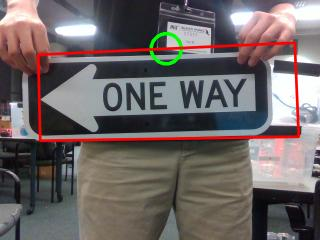

Match Percentage: 0.214%
Match Percentage: 0%
Match Percentage: 0.641%
Match Percentage: 0%
Match Percentage: 0%
Match Percentage: 0.214%
Match Percentage: 0.214%
Match Percentage: 0.427%
Match Percentage: 0.214%
Match Percentage: 0.214%
Match Percentage: 2.99%
Match Percentage: 3.85%
Match Percentage: 3.63%
Match Percentage: 7.48%
Match Percentage: 8.12%
Match Percentage: 10%
Match Percentage: 10.9%
Match Percentage: 9.4%
Match Percentage: 9.19%
Match Percentage: 10.5%
Match Percentage: 12%
Match Percentage: 11.3%
Match Percentage: 11.5%
Match Percentage: 8.97%
Match Percentage: 10.9%
Match Percentage: 11.3%
Match Percentage: 11.5%
Match Percentage: 10.3%
Match Percentage: 11.1%
Match Percentage: 10%
Match Percentage: 10.5%
Match Percentage: 10.5%
Match Percentage: 10.5%
Match Percentage: 12.6%
Match Percentage: 10.9%
Match Percentage: 10.7%
Match Percentage: 12.8%
Match Percentage: 11.3%
Match Percentage: 12.4%
Match Percentage: 12%
Match Percentage: 8.97%
Match Percentage: 11.5%
Mat

In [25]:
imagePath = 'one_way.png'
algorithm = 'orb'
# Reading in image
queryImage = cv2.imread(imagePath, 0)
queryImage = cv2.resize(queryImage, None, fx=0.2, fy=0.2, interpolation=cv2.INTER_AREA)
queryColumns = -80 #queryImage.shape[0]

kp_q, des_q = getKeypoints(queryImage, algorithm)


display = IPython.display.display('', display_id=1)


def signDetection_live(frame):
    isDetected, keypoint_query, keypooint_frame, good = signDetection(frame, kp_q, des_q, algorithm, MIN_MATCH_COUNT=10)

    frame, x_center = find_object(frame, queryImage, isDetected, keypoint_query, keypooint_frame, good, (0, 0, 255), queryColumns)

    show_frame(frame, display)
    
    #print(frame)
     
    cv2.imwrite('Sign_Detected.jpg', frame)
    
    time.sleep(0.1)

        
rc.run(signDetection_live, 10)

In [24]:
a, b = x[0], y[0]
c, d = x[4], y[4]

NameError: name 'x' is not defined